In [48]:
import numpy as np
from scipy import optimize
from numba import vectorize, float32, float64
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3dgpu import dft3d
from eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-05-03

In [49]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [50]:
structure_name = 'MOF-5'
structure = Structure.from_file('../structures/'+structure_name+'.cif')
Ncell = 2
structure.make_supercell(Ncell)
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn256 H768 C1536 O832
num_sites: 3392


In [51]:
coordinates = structure.cart_coords.T
L = np.array([l/Ncell for l in structure.lattice.lengths])
print('Cell dimensions: ', L)
Vcell = L[0]*L[1]*L[2]
print('Cell volume: ', Vcell)

Cell dimensions:  [25.86584 25.86584 25.86584]
Cell volume:  17305.325019903623


# Force Field for solid-fluid interaction

In [52]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11369,2.51610,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [53]:
# PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
# TraPPE: M.G. Martin, and J.I. Siepmann, J. Phys. Chem. B 102, 2569-2577 (1998).
# SoftSAFT: Blas, F. J., & Vega, L. F. (1998). Industrial and Engineering Chemistry Research, 5885(1996), 660–674.
fluid_molecule = 'CH4'
epsilon = {'TraPPE': 148.0, 'PCSAFT': 150.03, 'SoftSAFT': 147.302}
sigma = {'TraPPE': 3.73, 'PCSAFT': 3.704, 'SoftSAFT': 3.722}

fluid_forcefield = 'TraPPE'
epsilonff = epsilon[fluid_forcefield] # kelvin
sigmaff = sigma[fluid_forcefield] # angstrom
mff = 16.043
# epsilonff = 10.22 # kelvin
# sigmaff = 2.58 # angstrom
# mff = 4.0026

# Create the DFT object

In [54]:
Ngrid = 64
DFT = dft3d(gridsize=np.array([Ngrid,Ngrid,Ngrid]),ljmethod='MMFA')
DFT.Set_Geometry(L)

In [55]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
The grid is [64 64 64]
--- Geometry properties ---
Lx = 25.86584  A
Ly = 25.86584  A
Lz = 25.86584  A
Vol = 17305.325019903623  A³


In [56]:
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)

In [57]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 148.0  K
sigma = 3.73  A


## Defining the Temperature

In [58]:
kT = 200.0 # kelvin 
DFT.Set_Temperature(kT)

In [59]:
DFT.GetFluidTemperatureInformation()

Temperature = 200.0  K
Baker-Henderson diameter = 3.607  A


## Generating the External Potential

In [60]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [61]:
%%time

mss = 0.0

Vext = np.zeros((Ngrid,Ngrid,Ngrid))

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf = float(0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsf = float(np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))
    mss += float(forcefield["mass/u"][forcefield["atom"]==site.species_string])

    R = np.sqrt((DFT.X-structure.cart_coords[i,0]+L[0])**2 + (DFT.Y-structure.cart_coords[i,1]+L[1])**2 + (DFT.Z-structure.cart_coords[i,2]+L[2])**2)
    Vext[:] += ljpotential(R,epsilonsf,sigmasf)

mss = mss/(Ncell**3)

del R

DFT.Set_External_Potential(Vext)

CPU times: user 35 s, sys: 641 µs, total: 35 s
Wall time: 35 s


In [62]:
print('Unit cell mass: ', mss, ' u')

Unit cell mass:  6158.863039999983  u


In [63]:
rhocr = 1e27*mss/(Vcell*NA) #kg/m3 crystal MOF-5 density

In [64]:
print('Crystal Density: ',rhocr,' kg/m3')

Crystal Density:  590.9898672923852  kg/m3


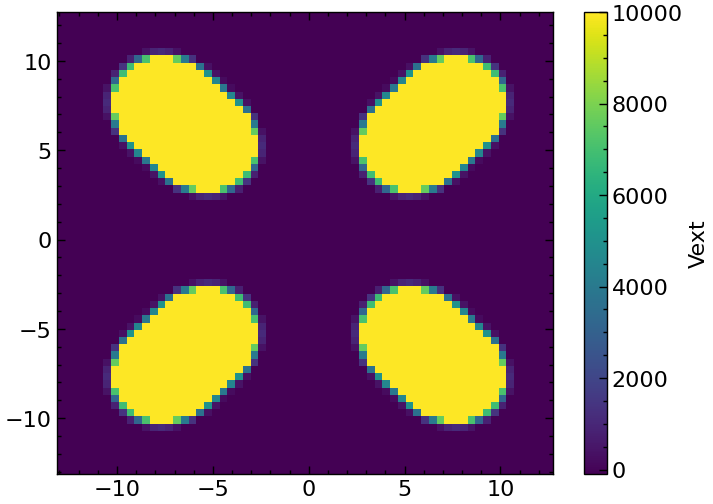

In [65]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
plt.colorbar(label='Vext')
plt.show()

In [66]:
# helium_void_fraction = Vpore/Vcell
helium_void_fraction = 0.852
# helium_void_fraction = 0.815

In [67]:
Vpore = helium_void_fraction*Vcell

In [68]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [69]:
def rhofromBARpressure(pbar):
    def func(x,p):
        return ljeos.p(x,kT)-p,ljeos.dpdrho(x,kT), ljeos.d2pdrho2(x,kT)
    if np.isscalar(pbar):
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar/(1e-5*kB)), method='halley')
        rho = sol.root
    else:
        rho = np.empty_like(pbar)
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
        rho[0] = sol.root
        for i in range(1,pbar.size):
            sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
            rho[i] = sol.root
    return rho

In [70]:
pbararray = np.hstack((np.arange(0.1,2.0,0.2),np.arange(2.,71,1.0))) # bulk pressure (in bar)

In [71]:
rhobarray = rhofromBARpressure(pbararray)

Text(0, 0.5, '$\\rho_b$ (molecules/$\\AA^{3}$)')

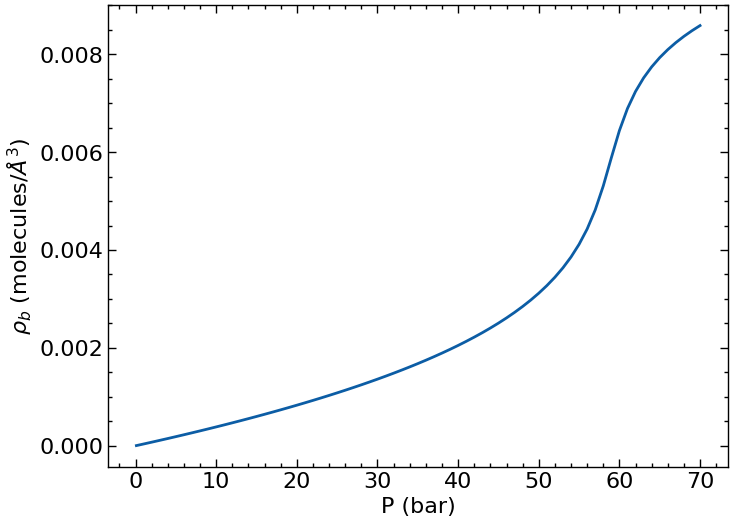

In [72]:
plt.plot(pbararray,rhobarray)
plt.xlabel(r'P (bar)')
plt.ylabel(r'$\rho_b$ (molecules/$\AA^{3}$)')

In [73]:
%%time

Nadsarray = np.zeros_like(rhobarray)

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

print('P (bar)\t rhob (AA^-3)\t Nabs(molecules/u.c.)')

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)

    DFT.Calculate_Equilibrium(alpha0=0.25,dt=0.2,rtol=1e-3,atol=1e-4,method='fire',logoutput=False)

    Nadsarray[i] = DFT.Nadstot
    print(pbararray[i],rhob,Nadsarray[i])

P (bar)	 rhob (AA^-3)	 Nabs(molecules/u.c.)


/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/examples/../src/pydftlj/dft3dgpu.py:179: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = torch.tensor(dphi3dnfuncWBI(self.n3.numpy()),dtype=torch.float32)


0.1 3.623586479187211e-06 2.63012433052063
0.30000000000000004 1.0883401378412605e-05 8.112326622009277
0.5000000000000001 1.816014962203029e-05 13.837488174438477
0.7000000000000001 2.5453924972000064e-05 19.722002029418945
0.9000000000000001 3.2764822178253315e-05 25.678138732910156
1.1000000000000003 4.009293699213262e-05 31.63899040222168
1.3000000000000003 4.743836618005606e-05 37.574729919433594
1.5000000000000004 5.480120753741078e-05 43.49639129638672
1.7000000000000004 6.218155990268058e-05 49.424747467041016
1.9000000000000004 6.957952317181244e-05 55.38107681274414
2.0 7.328514040555056e-05 58.37654495239258
3.0 0.00011058768324649857 87.79639434814453
4.0 0.00014834746067197537 110.89897155761719
5.0 0.00018657831752548547 125.08299255371094
6.0 0.00022529488655044538 133.7129669189453
7.0 0.00026451264720775717 139.52609252929688
8.0 0.000304247990037122 143.7891082763672
9.0 0.0003445182872119264 147.09877014160156
10.0 0.0003853419700284974 149.77008056640625
11.0 0.0004

In [ ]:
Marray = mff*Nadsarray

Nbulkarray = rhobarray*Vpore
Mbulk = mff*Nbulkarray

In [ ]:
Nidealarray = rhobarray*torch.exp(-DFT.beta*DFT.Vext[:,:,:].cpu()).sum().numpy()*DFT.dV
Midealarray = mff*Nidealarray

In [ ]:
Nexcarray = Nadsarray - rhobarray*Vpore
Mexcarray = Nexcarray*mff

In [ ]:
df = pd.DataFrame()
df['Pressure (bar)'] = pbararray
df['Bulk adsorption (molecules/uc)'] = Nbulkarray
df['Bulk adsorption (%w.t.)'] = 100*Mbulk/(mss+Mbulk)
df['Bulk adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nbulkarray/Vcell
df['Ideal adsorption (molecules/uc)'] = Nidealarray
df['Ideal adsorption (%w.t.)'] = 100*Midealarray/(mss+Midealarray)
df['Ideal adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nidealarray/Vcell
df['Absolute adsorption (molecules/uc)'] = Nadsarray
df['Absolute adsorption (mg/g)'] = 1e3*Marray/mss
df['Absolute adsorption (%w.t.)'] = 100*Marray/(mss+Marray)
df['Absolute adsorption (mol/kg)'] = 1e3*Nadsarray/mss
df['Absolute adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nadsarray/Vcell
df['Excess adsorption (molecules/uc)'] = Nexcarray
df['Excess adsorption (mg/g)'] = 1e3*Mexcarray/mss
df['Excess adsorption (%w.t.)'] = 100*Mexcarray/(mss+Mexcarray)
df['Excess adsorption (mol/kg)'] = 1e3*Nexcarray/mss
df['Excess adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nexcarray/Vcell

In [ ]:
df.head()

,Pressure (bar),Bulk adsorption (molecules/uc),Bulk adsorption (%w.t.),Bulk adsorption (cm^3 STP/cm^3),Ideal adsorption (molecules/uc),Ideal adsorption (%w.t.),Ideal adsorption (cm^3 STP/cm^3),Absolute adsorption (molecules/uc),Absolute adsorption (mg/g),Absolute adsorption (%w.t.),Absolute adsorption (mol/kg),Absolute adsorption (cm^3 STP/cm^3),Excess adsorption (molecules/uc),Excess adsorption (mg/g),Excess adsorption (%w.t.),Excess adsorption (mol/kg),Excess adsorption (cm^3 STP/cm^3)
0,0.1,0.044511,0.011593,0.095732,0.841604,0.218747,1.810071,0.843092,2.196139,0.219133,0.136891,1.813272,0.798580,2.080193,0.207587,0.129664,1.717539
1,0.3,0.133624,0.034795,0.287390,2.526507,0.653818,5.433863,2.544653,6.628474,0.658483,0.413169,5.472889,2.411029,6.280402,0.624121,0.391473,5.185499
2,0.5,0.222856,0.058017,0.479306,4.213678,1.085689,9.062531,4.262616,11.103535,1.098160,0.692111,9.167783,4.039760,10.523025,1.041344,0.655926,8.688478
3,0.7,0.312209,0.081260,0.671480,5.903122,1.514396,12.696087,5.997184,15.621849,1.538156,0.973749,12.898390,5.684976,14.808588,1.459249,0.923056,12.226910
4,0.9,0.401682,0.104523,0.863913,7.594844,1.939974,16.334543,7.744402,20.173113,1.977421,1.257440,16.656203,7.342720,19.126787,1.876782,1.192220,15.792290


(0.0, 1000.0)

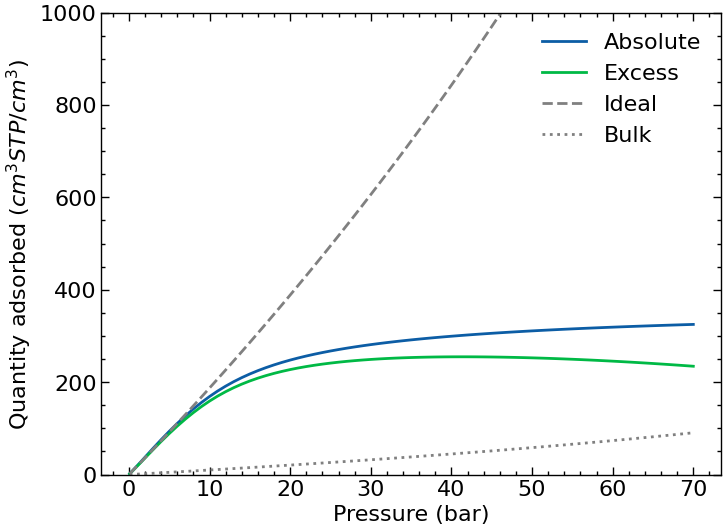

In [ ]:
plt.plot(df['Pressure (bar)'],df['Absolute adsorption (cm^3 STP/cm^3)'],label='Absolute')
plt.plot(df['Pressure (bar)'],df['Excess adsorption (cm^3 STP/cm^3)'],label='Excess')
plt.plot(df['Pressure (bar)'],df['Ideal adsorption (cm^3 STP/cm^3)'],'--',color='grey',label='Ideal')
plt.plot(df['Pressure (bar)'],df['Bulk adsorption (cm^3 STP/cm^3)'],':',color='grey',label='Bulk')
plt.legend(loc='best')
plt.ylabel('Quantity adsorbed $(cm^3 STP/cm^3)$')
plt.xlabel('Pressure (bar)')
plt.ylim(0,1000)

In [ ]:
df.to_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ngrid)+'-ljmethod='+str(DFT.ljmethod)+'.dat', index=False,sep='\t')

In [ ]:
dft200K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=200.0K-N=64.dat',sep='\t')
dft240K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=240.0K-N=64-ljmethod=MMFA.dat',sep='\t')
dft270K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=270.0K-N=64-ljmethod=MMFA.dat',sep='\t')
dft300K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=300.0K-N=64-ljmethod=MMFA.dat',sep='\t')


dft200K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=200.0K-N=32.dat',sep='\t')
dft240K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=240.0K-N=32.dat',sep='\t')
dft270K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=270.0K-N=32.dat',sep='\t')
dft300K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=300.0K-N=32-ljmethod=WDA.dat',sep='\t')

# Plotting the results

In [ ]:
exp_data = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='CH4-MOF5')

(0.0, 60.0)

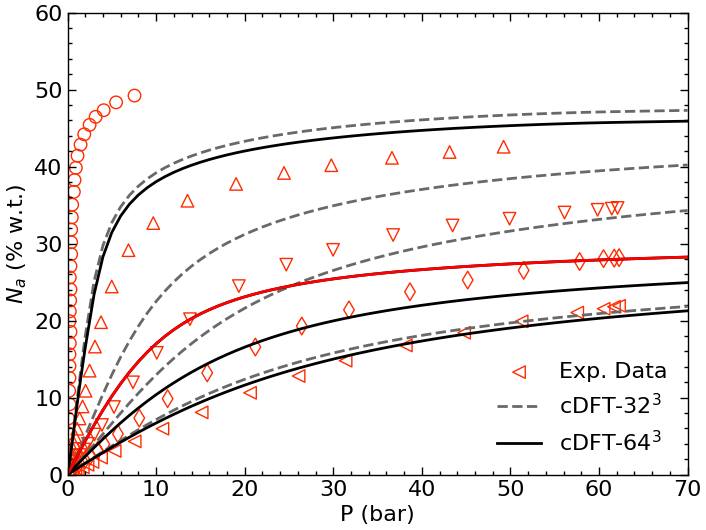

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['P(bar)-300K'],exp_data['Na(%wt)-300K'],marker='<',edgecolors='C3',facecolors='none',label='Exp. Data')
plt.scatter(exp_data['P(bar)-270K'],exp_data['Na(%wt)-270K'],marker='d',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['P(bar)-240K'],exp_data['Na(%wt)-240K'],marker='v',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['P(bar)-200K'],exp_data['Na(%wt)-200K'],marker='^',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['P(bar)-150K'],exp_data['Na(%wt)-150K'],marker='o',edgecolors='C3',facecolors='none')

plt.plot(dft240K_data32['Pressure (bar)'],dft240K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey',label='cDFT-32$^3$')
plt.plot(dft270K_data32['Pressure (bar)'],dft270K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft200K_data32['Pressure (bar)'],dft200K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')

plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Absolute adsorption (%w.t.)'],'-',color='k',label='cDFT-64$^3$')
plt.plot(dft270K_data['Pressure (bar)'],dft270K_data['Absolute adsorption (%w.t.)'],'-',color='k')
plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Absolute adsorption (%w.t.)'],'-',color='k')
plt.plot(dft200K_data['Pressure (bar)'],dft200K_data['Absolute adsorption (%w.t.)'],'-',color='k')

plt.plot(df['Pressure (bar)'],df['Absolute adsorption (%w.t.)'],'-',color='red')

plt.legend(loc='lower right')
plt.xlabel('P (bar)')
plt.ylabel('$N_a$ (% w.t.)')
plt.xlim(0,70)
plt.ylim(0,60)
# plt.ylim(0,20)

(0.0, 60.0)

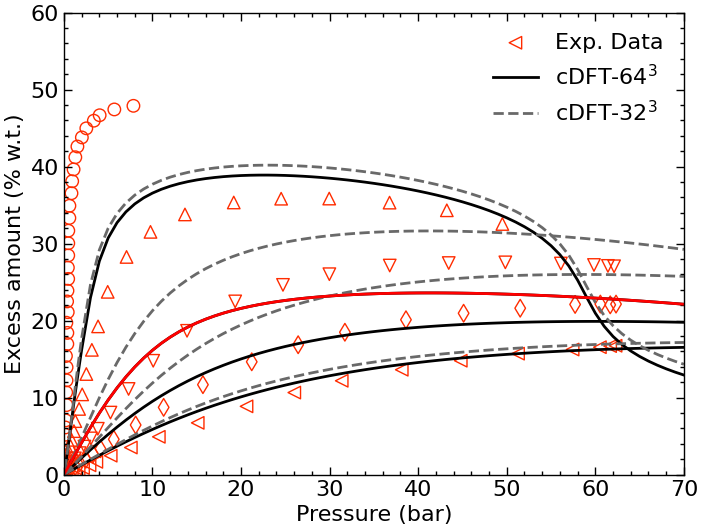

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['Pexc(bar)-300K'],exp_data['Nexc(%wt)-300K'],marker='<',edgecolors='C3',facecolors='none',label='Exp. Data')
plt.scatter(exp_data['Pexc(bar)-270K'],exp_data['Nexc(%wt)-270K'],marker='d',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['Pexc(bar)-240K'],exp_data['Nexc(%wt)-240K'],marker='v',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['Pexc(bar)-200K'],exp_data['Nexc(%wt)-200K'],marker='^',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['Pexc(bar)-150K'],exp_data['Nexc(%wt)-150K'],marker='o',edgecolors='C3',facecolors='none')

plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Excess adsorption (%w.t.)'],'-',color='k',label='cDFT-64$^3$')
plt.plot(dft270K_data['Pressure (bar)'],dft270K_data['Excess adsorption (%w.t.)'],'-',color='k')
plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Excess adsorption (%w.t.)'],'-',color='k')
plt.plot(dft200K_data['Pressure (bar)'],dft200K_data['Excess adsorption (%w.t.)'],'-',color='k')

plt.plot(dft240K_data32['Pressure (bar)'],dft240K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey',label='cDFT-32$^3$')
plt.plot(dft270K_data32['Pressure (bar)'],dft270K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft200K_data32['Pressure (bar)'],dft200K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')


plt.plot(df['Pressure (bar)'],df['Excess adsorption (%w.t.)'],'-',color='red')

plt.legend(loc='upper right')
plt.xlabel('Pressure (bar)')
plt.ylabel('Excess amount (% w.t.)')
plt.xlim(0,70)
plt.ylim(0,60)

In [ ]:
exp_data2 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Duren2004.xls',sheet_name='IRMOF-1')

(0.0, 150.0)

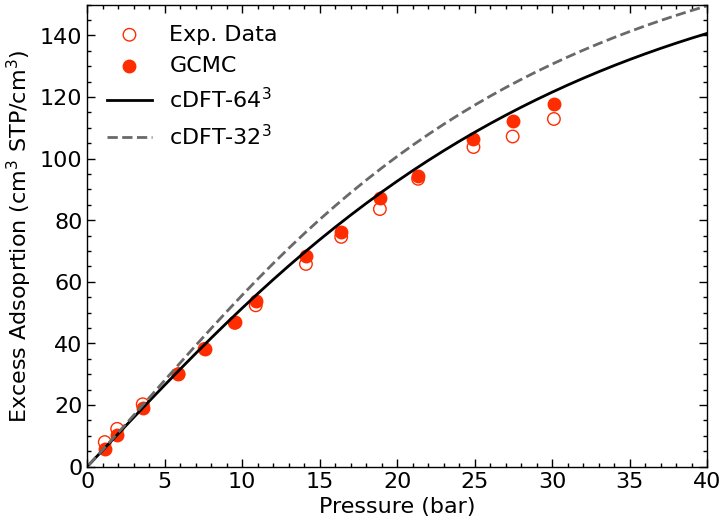

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Excess adsorption (cm^3 STP/cm^3)'],marker='o',edgecolors='C3',facecolors='none',label='Exp. Data')
plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Sim Excess adsorption (cm^3 STP/cm^3)'],marker='o',edgecolors='C3',facecolors='C3',label='GCMC')

plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Excess adsorption (cm^3 STP/cm^3)'],'-',color='k',label='cDFT-64$^3$')

plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Excess adsorption (cm^3 STP/cm^3)'],'--',color='dimgrey',label='cDFT-32$^3$')

# plt.plot(df['Pressure (bar)'],df['Excess adsorption (cm^3 STP/cm^3)'],'-',color='red')

plt.legend(loc='upper left')
plt.xlabel('Pressure (bar)')
plt.ylabel('Excess Adsoprtion (cm$^3$ STP/cm$^3$)')
plt.xlim(0,40)
plt.ylim(0,150)